# Population Estimates: Compute outcome estimates using existing CF annotations

In [1]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * Outputs from Pop-Estimates-CF-Annotations
parcel_density = pd.read_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density.csv'), 
                             dtype={'year': str, 'GEOID': str})
cbg_density = pd.read_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'cbg_density.csv'), 
                          dtype={'GEOID': str})
parcel_growth = pd.read_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth.csv'))
CF_area_coverage = gpd.read_file(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'CF_area_coverage'))

# * San Jose permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])

In [4]:
# Get neighborhood shapefiles
neighborhoods = cbg_income_2016_SJ.dissolve('neighborho').reset_index()
neighborhoods = neighborhoods[['neighborho', 'geometry']]

## 1. Mean small building density
Small building density across neighborhoods and the three time periods.

In [29]:
# Add number of total parcels in each CBG
cbg_nparcels = sj_parcels_cbgs.groupby('GEOID')['APN'].count().reset_index()
cbg_density = pd.merge(cbg_density, cbg_nparcels, how='left', validate='many_to_one')
cbg_density.rename(columns={'APN': 'N_parcels'}, inplace=True)

# Add percentage of sampled parcels
cbg_density['perc_sampled'] = cbg_density['N_parcels_sampled'] / cbg_density['N_parcels']

# Compute total sampled parcels per year/neighborhood
sampled_parcels = cbg_density.fillna(-1).groupby(
    ['year', 'neighborho'])['N_parcels_sampled'].sum().reset_index()

# Compute weighted mean density and weighted total small buildings
cbg_density['weighted_mean_density_sampled'] = cbg_density.apply(
    lambda row: 0 if pd.isnull(row['neighborho']) else row['mean_density'] * row['N_parcels_sampled'] / sampled_parcels.loc[
        (sampled_parcels['year'] == row['year']) & (
            sampled_parcels['neighborho'] == row['neighborho'])].iloc[0]['N_parcels_sampled'], 
    axis=1)

# Weighted mean and SD estimates
aggregates = cbg_density.groupby(['year', 'neighborho']).agg(
    {'weighted_mean_density_sampled': ['sum']}).reset_index()
aggregates.columns = ['-'.join(l) for l in aggregates.columns]

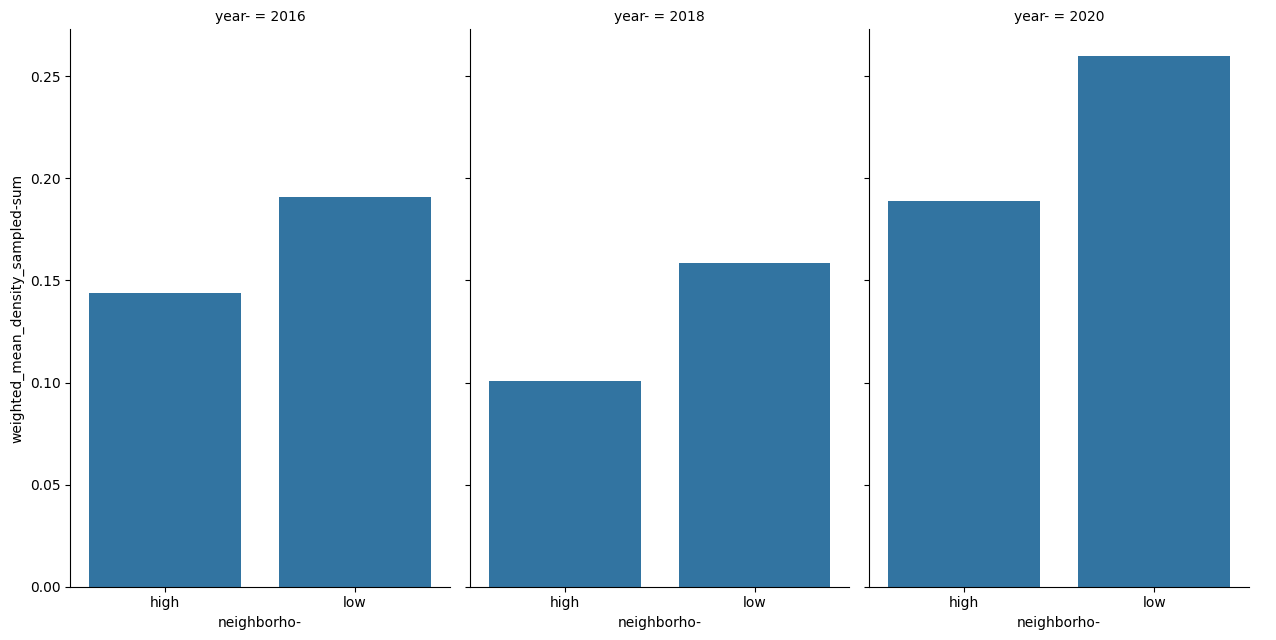

In [30]:
g = sns.FacetGrid(aggregates, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'weighted_mean_density_sampled-sum')
g.add_legend()
plt.show()

## 2. Permitted portion of small building growth
We estimate the following outcome using CF annotations`(highpermit20-highpermit16)/(high20-high16) - (lowpermit20-lowpermit16)/(low20-low16)`

## 2.1 No geospatial mapping
Computes outcome as total permits issued over the total additions of small buildings for both neighborhoods.

[INFO] Number of construction, addition & alteration permits: 14384
[INFO] Number of construction, addition & alteration permits in CF area: 1298
  neighborho  new_sbuilds_16_20  new_permits_16_20  perm_rate
0       high                362               78.0   0.215470
1        low                601              193.0   0.321131


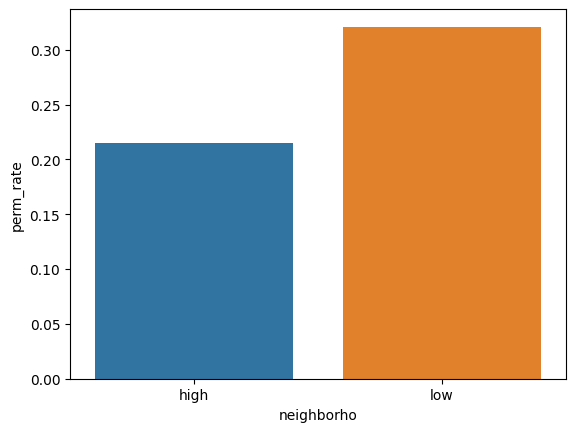

In [35]:
# Compute new small buildings by neighborhoood type in the CF universe of parcels
rate_outcome = parcel_density.groupby(['neighborho', 'year'])['parcel_density'].sum().reset_index()
rate_outcome = rate_outcome.pivot(
    index='neighborho', columns='year', values='parcel_density').reset_index()
rate_outcome['new_sbuilds_16_20'] = rate_outcome['2020'] - rate_outcome['2016']

# Compute new "ADU" permits by neighborhood type
permits_nongeo = gpd.GeoDataFrame(
    data=permits[['OBJECTID_left', 'issue_year', 'geometry_permit']], 
    geometry='geometry_permit', crs='EPSG:4326')
print('[INFO] Number of construction, addition & alteration permits: {}'.format(len(permits_nongeo)))

# * Limit permits to CF area coverage
permits_nongeo = gpd.clip(permits_nongeo, CF_area_coverage)
print('[INFO] Number of construction, addition & alteration permits in CF area: {}'.format(
    len(permits_nongeo)))

# * Assign permits to neighborhoods
n_permits = len(permits_nongeo)
permits_nongeo = permits_nongeo.sjoin(neighborhoods, how='left', predicate='intersects')
assert(len(permits_nongeo) == n_permits)

permits_nongeo['issue_year'] = permits_nongeo['issue_year'].astype(str)

# * Aggregate and compute change in permits
permits_nongeo = permits_nongeo.groupby(
    ['neighborho', 'issue_year'])['OBJECTID_left'].count().reset_index()

permits_nongeo = permits_nongeo.pivot(
    index='neighborho', columns='issue_year', values='OBJECTID_left').reset_index()

permits_nongeo['cumulative_17_20'] = permits_nongeo.apply(
    lambda row: row['2017'] + row['2018'] + row['2019'] + row['2020'], axis=1)

permits_nongeo['new_permits_16_20'] = permits_nongeo['cumulative_17_20'] - permits_nongeo['2016']

# Merge small building and permit data
rate_outcome = pd.merge(
    rate_outcome[['neighborho', 'new_sbuilds_16_20']], permits_nongeo[['neighborho', 'new_permits_16_20']], 
    validate='one_to_one')

rate_outcome['perm_rate'] = rate_outcome['new_permits_16_20'] / rate_outcome['new_sbuilds_16_20']

print(rate_outcome)
sns.barplot(rate_outcome, x='neighborho', y='perm_rate')
plt.show()

## 2.2 Geospatial mapping
Compute permitted and unpermitted small building density at the parcel level as permitted small buildings = min(parcel permits, parcel small build), and unpermitted = total small building in parcel - permitted small buildings

In [27]:
# Aggregate permits at the parcel level to figure out number of permits per parcel
parcel_permits = permits.groupby(['APN_parcel', 'issue_year'])['OBJECTID_left'].count().reset_index()
parcel_permits = parcel_permits.pivot(
    index='APN_parcel', columns='issue_year', values='OBJECTID_left').reset_index()

# Count number of permits pre-2017 and pre-2021
pre_16_cols = [c for c in parcel_permits.columns if (type(c) == int) and c < 2016]
pre_17_cols = [c for c in parcel_permits.columns if (type(c) == int) and c < 2017]
pre_21_cols = [c for c in parcel_permits.columns if (type(c) == int) and c < 2021]

parcel_permits['<=2015'] = parcel_permits.apply(
    lambda row: row[pre_16_cols].sum(), axis=1)
parcel_permits['<=2016'] = parcel_permits.apply(
    lambda row: row[pre_17_cols].sum(), axis=1)
parcel_permits['<=2020'] = parcel_permits.apply(
    lambda row: row[pre_21_cols].sum(), axis=1)
parcel_permits['2016_20'] = parcel_permits.apply(
    lambda row: row['<=2020'] - row['<=2015'], axis=1)

parcel_permits = parcel_permits[['APN_parcel', '<=2016', '<=2020', '2016_20']]
parcel_permits.rename(columns={'APN_parcel': 'APN'}, inplace=True)

In [32]:
# Merge permit and small building data
rate_outcome_geo = parcel_density.copy()
rate_outcome_geo = pd.merge(
    rate_outcome_geo, parcel_permits[['APN', '<=2016', '<=2020']], on='APN', 
    how='left', validate='many_to_one')

# Fill parcel columns with zeros
rate_outcome_geo[['<=2016', '<=2020']] = rate_outcome_geo[
    ['<=2016', '<=2020']].fillna(value=0)

# Drop 2018 data
rate_outcome_geo = rate_outcome_geo.loc[rate_outcome_geo['year'] != '2018']

# Compute unpermitted and permitted small building density at the parcel level
rate_outcome_geo['permitted_sb'] = rate_outcome_geo.apply(
    lambda row: min(row['parcel_density'], row['<=2016']) if row[
        'year'] == '2016' else min(row['parcel_density'], row['<=2020']), 
    axis=1)
rate_outcome_geo['unpermitted_sb'] = rate_outcome_geo[
    'parcel_density'] - rate_outcome_geo['permitted_sb']

assert rate_outcome_geo['unpermitted_sb'].sum() + rate_outcome_geo[
    'permitted_sb'].sum() == rate_outcome_geo['parcel_density'].sum()

# Pivot table so we can compute change in permitted vs change in unpermitted for each parcel
rate_outcome_geo = rate_outcome_geo.pivot(
    index=['APN', 'GEOID', 'neighborho'], columns='year', 
    values=['permitted_sb', 'unpermitted_sb']).reset_index()
rate_outcome_geo.columns = ['-'.join(l) if l[1] != '' else l[0] for l in rate_outcome_geo.columns]

# Compute change in permitted and unpermitted change
# Assumptions:
# No small building demolitions
# No small building conversions (permits aren't acquired retroactively)

for rate_kind in ['permitted', 'unpermitted']:
    rate_outcome_geo['{}_change'.format(rate_kind)] = rate_outcome_geo.apply(
        lambda row: max(0, row['{}_sb-2020'.format(rate_kind)] - row['{}_sb-2016'.format(rate_kind)]),
        axis=1)
print('[INFO] Number of parcels: {}'.format(len(rate_outcome_geo['APN'].unique())))

[INFO] Number of parcels: 16771


Aggregate by high/low income neighborhood (split at 50th percentile).

  neighborho  permitted_change  unpermitted_change  total_change  perm_rate
0       high              52.0               725.0         777.0   0.066924
1        low              58.0              1040.0        1098.0   0.052823


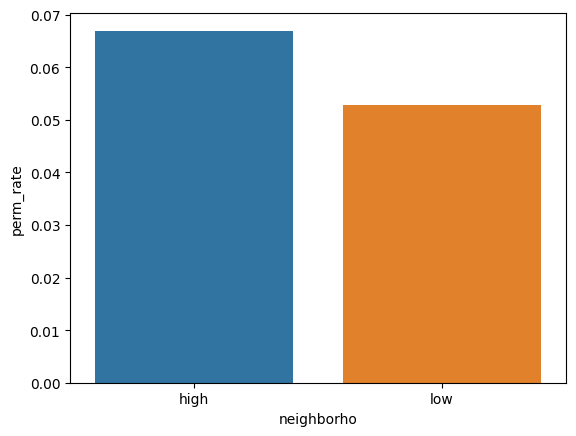

In [33]:
# Aggregate by neighborhood
rate_outcome_geo_agg = rate_outcome_geo.groupby('neighborho')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

# Compute permitted change
rate_outcome_geo_agg['total_change'] = rate_outcome_geo_agg['permitted_change'] + rate_outcome_geo_agg['unpermitted_change']
rate_outcome_geo_agg['perm_rate'] = rate_outcome_geo_agg.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print(rate_outcome_geo_agg)
sns.barplot(rate_outcome_geo_agg, x='neighborho', y='perm_rate')
plt.show()

Aggregate by quartiles based on CBG median income.

        quartile  permitted_change  unpermitted_change  total_change  \
0            Low              33.0               596.0         629.0   
1   Low-Moderate              25.0               444.0         469.0   
2  High-moderate              19.0               385.0         404.0   
3           High              33.0               340.0         373.0   

   perm_rate  
0   0.052464  
1   0.053305  
2   0.047030  
3   0.088472  


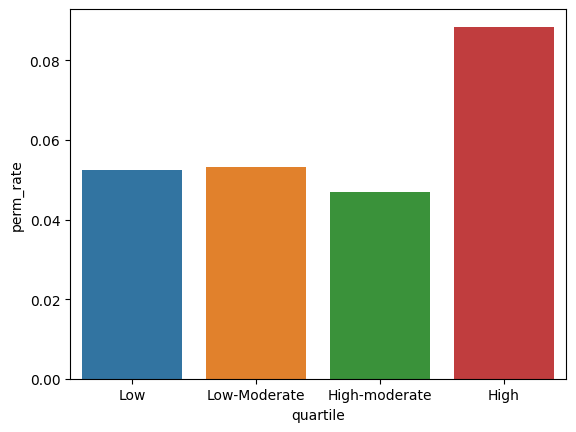

In [34]:
# Generate decile column
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

# Disaggregate further (by quartile)
# * Add income strata data
rate_outcome_geo_disag = rate_outcome_geo.copy()
rate_outcome_geo_disag = pd.merge(
    rate_outcome_geo_disag, cbg_income_2016_SJ[['GEOID', 'quartile', 'strata_inc']], 
    how='left', validate='many_to_one')

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
rate_outcome_geo_disag['neighborhood'] = rate_outcome_geo_disag['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}
rate_outcome_geo_disag['quartile'] = rate_outcome_geo_disag['quartile'].apply(
    lambda quartile: quartile_names[quartile])

# Aggregate by neighborhood
rate_outcome_geo_disag_neigh = rate_outcome_geo_disag.groupby(['neighborhood'])[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()
#rate_outcome_geo_disag_neigh = rate_outcome_geo_disag.copy()

rate_outcome_geo_disag_neigh['total_change'] = rate_outcome_geo_disag_neigh[
    'permitted_change'] + rate_outcome_geo_disag_neigh['unpermitted_change']
rate_outcome_geo_disag_neigh['perm_rate'] = rate_outcome_geo_disag_neigh.apply(
    lambda row: None if row['total_change']==0 else row['permitted_change'] / row['total_change'] , 
    axis=1)

# Aggregate by quartile
rate_outcome_geo_disag = rate_outcome_geo_disag.groupby('quartile')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_geo_disag['total_change'] = rate_outcome_geo_disag[
    'permitted_change'] + rate_outcome_geo_disag['unpermitted_change']
rate_outcome_geo_disag['perm_rate'] = rate_outcome_geo_disag.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print(rate_outcome_geo_disag)
sns.barplot(rate_outcome_geo_disag, x='quartile', y='perm_rate')
plt.show()

In [45]:
rate_outcome_geo_disag_neigh.groupby('neighborhood')['perm_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
neighborhood,,,,,,,,
High,1.0,0.088472,NaN,0.088472,0.088472,0.088472,0.088472,0.088472
Low,1.0,0.051265,NaN,0.051265,0.051265,0.051265,0.051265,0.051265


Base-level of permitting vs unpermitting

In [98]:
permitting_levels = rate_outcome_geo.copy()
permitting_levels = pd.merge(
    permitting_levels, cbg_income_2016_SJ[['GEOID', 'quartile']], 
    how='left', validate='many_to_one')

In [99]:
permitting_levels_quart = permitting_levels.groupby('quartile')[[
    'permitted_sb-2016', 'permitted_sb-2020', 'unpermitted_sb-2016',
    'unpermitted_sb-2020']].sum().reset_index()
for year in ['2016', '2020']:
    permitting_levels_quart['prop_{}'.format(year)] = permitting_levels_quart.apply(
        lambda row: row['permitted_sb-{}'.format(year)] / (
            row['permitted_sb-{}'.format(year)] + row['unpermitted_sb-{}'.format(year)]), 
        axis=1)
permitting_levels_quart

,quartile,permitted_sb-2016,permitted_sb-2020,unpermitted_sb-2016,unpermitted_sb-2020,prop_2016,prop_2020
0,IS_0,26.0,47.0,784.0,1138.0,0.032099,0.039662
1,IS_1,37.0,58.0,817.0,1022.0,0.043326,0.053704
2,IS_2,21.0,36.0,429.0,684.0,0.046667,0.050000
3,IS_3,32.0,60.0,679.0,743.0,0.045007,0.074720


In [96]:
permitting_levels_quart = pd.melt(
    permitting_levels_quart, id_vars='quartile', value_vars=['prop_2016', 'prop_2020'], 
    var_name='prop_year')
permitting_levels_quart['year'] = permitting_levels_quart['prop_year'].str.replace('prop_', '')

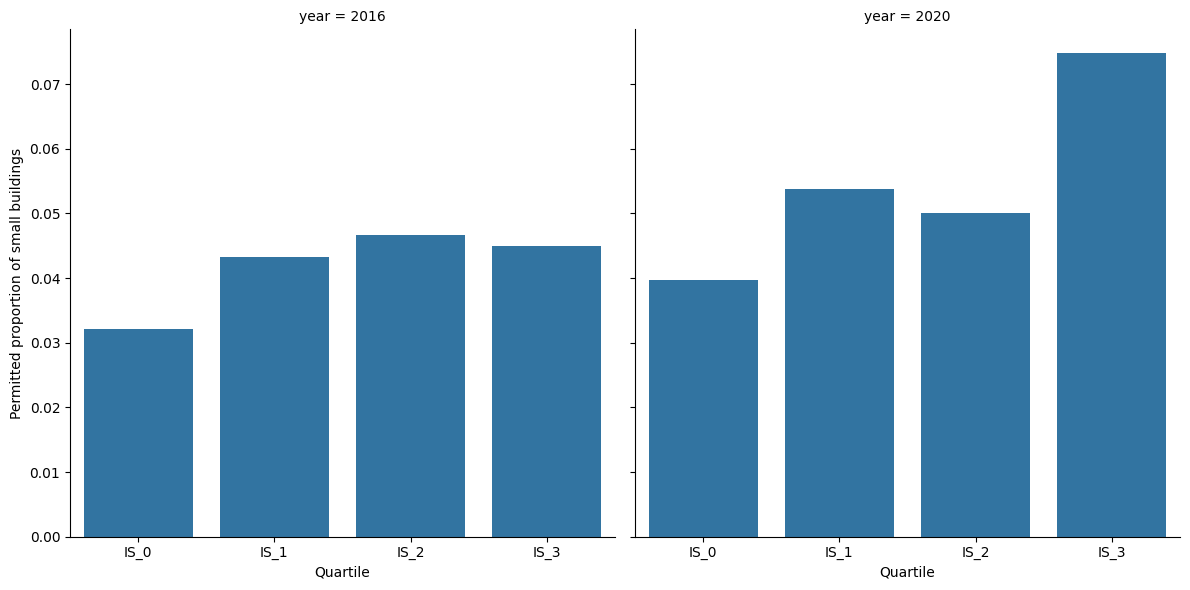

In [97]:
g = sns.FacetGrid(permitting_levels_quart, col='year', height=6, aspect=1)
g = g.map_dataframe(sns.barplot, x="quartile", y='value')
g.set_axis_labels("Quartile")
g.set_ylabels('Permitted proportion of small buildings')
plt.show()

### 2.3 Geospatial mapping (new small buildings)
Directly match CF dots at the building-level to identify new buildings; still use parcel-level matching to permits to classify new small buildings as permitted vs unpermitted. 

In [28]:
# Merge permit and small building data
rate_outcome_geo_mapped = parcel_growth.copy()
rate_outcome_geo_mapped = pd.merge(
    rate_outcome_geo_mapped, parcel_permits[['APN', '2016_20']], on='APN', 
    how='left', validate='many_to_one')

# Fill parcel columns with zeros
rate_outcome_geo_mapped[['2016_20']] = rate_outcome_geo_mapped[['2016_20']].fillna(value=0)

# Compute unpermitted and permitted new small buildings at the parcel level
rate_outcome_geo_mapped['permitted_change'] = rate_outcome_geo_mapped.apply(
    lambda row: min(row['new_small_build'], row['2016_20']), axis=1)
rate_outcome_geo_mapped['unpermitted_change'] = rate_outcome_geo_mapped[
    'new_small_build'] - rate_outcome_geo_mapped['permitted_change']

assert rate_outcome_geo_mapped['unpermitted_change'].sum() + rate_outcome_geo_mapped[
    'permitted_change'].sum() == rate_outcome_geo_mapped['new_small_build'].sum()

# Add GEOID
rate_outcome_geo_mapped = pd.merge(
    rate_outcome_geo_mapped, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

In [29]:
# Generate decile column
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

# Disaggregate by quartile
# * Add income strata data
rate_outcome_geo_mapped_disag = rate_outcome_geo_mapped.copy()
rate_outcome_geo_mapped_disag = pd.merge(
    rate_outcome_geo_mapped_disag, cbg_income_2016_SJ[['GEOID', 'quartile', 'strata_inc']], 
    how='left', validate='many_to_one')

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
rate_outcome_geo_mapped_disag['neighborhood'] = rate_outcome_geo_mapped_disag['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}
rate_outcome_geo_mapped_disag['quartile'] = rate_outcome_geo_mapped_disag['quartile'].apply(
    lambda quartile: quartile_names[quartile])

In [30]:
rate_outcome_geo_mapped_disag.head()

,APN,new_small_build,2016_20,permitted_change,unpermitted_change,GEOID,quartile,strata_inc,neighborhood
0,70616068,0,0.0,0.0,0.0,060855120352,High-moderate,IS_35,Low
1,23032111,0,0.0,0.0,0.0,060855051001,Low,IS_12,Low
2,43948043,0,0.0,0.0,0.0,060855030021,High-moderate,IS_29,Low
3,43941077,0,0.0,0.0,0.0,060855030022,High,IS_39,High
4,42132050,0,0.0,0.0,0.0,060855027024,High-moderate,IS_35,Low


At the neighborhood level (75 percentile)
  neighborhood  permitted_change  unpermitted_change  total_change  perm_rate
0         High              16.0               787.0         803.0   0.019925
1          Low              43.0              2942.0        2985.0   0.014405


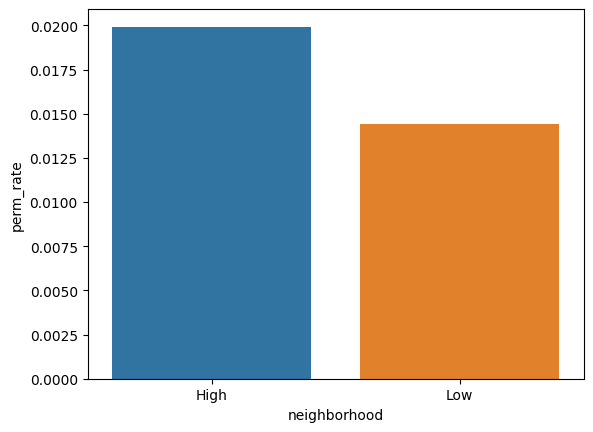

At the quartile level
        quartile  permitted_change  unpermitted_change  total_change  \
0            Low              17.0              1168.0        1185.0   
1   Low-Moderate              17.0              1063.0        1080.0   
2  High-moderate               9.0               711.0         720.0   
3           High              16.0               787.0         803.0   

   perm_rate  
0   0.014346  
1   0.015741  
2   0.012500  
3   0.019925  


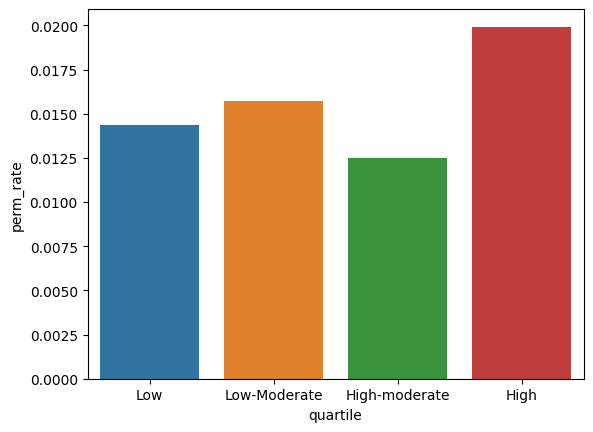

In [31]:
# Aggregate by neighborhood
rate_outcome_geo_mapped_disag_neigh = rate_outcome_geo_mapped_disag.groupby(['neighborhood'])[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_geo_mapped_disag_neigh['total_change'] = rate_outcome_geo_mapped_disag_neigh[
    'permitted_change'] + rate_outcome_geo_mapped_disag_neigh['unpermitted_change']
rate_outcome_geo_mapped_disag_neigh['perm_rate'] = rate_outcome_geo_mapped_disag_neigh.apply(
    lambda row: None if row['total_change']==0 else row['permitted_change'] / row['total_change'] , 
    axis=1)

print('At the neighborhood level (75 percentile)')
print(rate_outcome_geo_mapped_disag_neigh)
sns.barplot(rate_outcome_geo_mapped_disag_neigh, x='neighborhood', y='perm_rate')
plt.show()

# Aggregate by quartile
rate_outcome_geo_mapped_disag = rate_outcome_geo_mapped_disag.groupby('quartile')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_geo_mapped_disag['total_change'] = rate_outcome_geo_mapped_disag[
    'permitted_change'] + rate_outcome_geo_mapped_disag['unpermitted_change']
rate_outcome_geo_mapped_disag['perm_rate'] = rate_outcome_geo_mapped_disag.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print('At the quartile level')
print(rate_outcome_geo_mapped_disag)
sns.barplot(rate_outcome_geo_mapped_disag, x='quartile', y='perm_rate')
plt.show()

In [36]:
rate_outcome_geo_mapped_disag

,quartile,permitted_change,unpermitted_change,total_change,perm_rate
0,Low,17.0,1168.0,1185.0,0.014346
1,Low-Moderate,17.0,1063.0,1080.0,0.015741
2,High-moderate,9.0,711.0,720.0,0.012500
3,High,16.0,787.0,803.0,0.019925


## 3. Small building growth distribution

In [37]:
sb_growth = parcel_density.copy()
sb_growth = sb_growth.loc[sb_growth['year'] != '2018']

sb_growth = sb_growth.pivot(
    index=['APN', 'GEOID'], columns='year', values='parcel_density').reset_index()

sb_growth['num_new_sbs'] = sb_growth.apply(
    lambda row: max(0, row['2020'] - row['2016']), axis=1)

# Add neighborhood
high_income_cbgs = cbg_income_2016_SJ.loc[cbg_income_2016_SJ['quartile'] == 'IS_3']['GEOID'].unique()
print('Number of high income CBGS (defined by 75%): {}'.format(len(high_income_cbgs)))

sb_growth['neighborhood'] = sb_growth['GEOID'].apply(
    lambda geoid: 'high' if geoid in high_income_cbgs else 'low')

sb_growth.groupby(['neighborhood', 'num_new_sbs'])['APN'].count().reset_index()

Number of high income CBGS (defined by 75%): 160


,neighborhood,num_new_sbs,APN
0,high,0,3319
1,high,1,314
2,high,2,22
3,high,3,3
4,low,0,11768
5,low,1,1225
6,low,2,110
7,low,3,7
8,low,4,2
9,low,8,1
